In [1]:
!wget https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv

--2022-08-08 16:44:38--  https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480130 (469K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 468.88K  --.-KB/s    in 0.003s  

2022-08-08 16:44:38 (144 MB/s) - ‘spam.csv’ saved [480130/480130]



In [2]:
!pip3 install tensorflow_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 34.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 438 kB 66.9 MB/s 
     |████████████████████████████████| 1.6 MB 55.3 MB/s 
     |████████████████████████████████| 5.8 MB 61.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [4]:
df = pd.read_csv('spam.csv')

In [5]:
df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

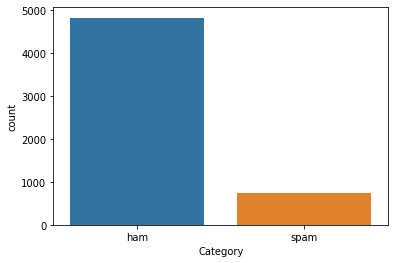

In [7]:
import seaborn as sns
sns.countplot(x = 'Category',data=df)

In [8]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [9]:
# DownSampling to generate a balanced datasets(Need not always be accurate)

df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [11]:
df_ham_down = df_ham.sample(df_spam.shape[0])

In [12]:
df_ham_down.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_spam,df_ham_down])

In [14]:
df_balanced.shape

(1494, 2)

In [15]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [16]:
df_balanced['spam'] = df_balanced['Category'].map({'spam':1,'ham':0})

In [17]:
df_balanced.sample(5)

,Category,Message,spam
3420,spam,Do you want a new Video phone? 600 anytime any...,1
1449,spam,As a registered optin subscriber ur draw 4 £10...,1
4658,spam,PRIVATE! Your 2003 Account Statement for shows...,1
2868,ham,"Mum, i've sent you many many messages since i ...",0
1350,spam,FREE2DAY sexy St George's Day pic of Jordan!Tx...,1


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [19]:
X_train.head()

3929       Babe ? I lost you ... Will you try rebooting ?
1947    Hey we can go jazz power yoga hip hop kb and y...
2473    Final Chance! Claim ur £150 worth of discount ...
3141    sexy sexy cum and text me im wet and warm and ...
1041    Today am going to college so am not able to at...
Name: Message, dtype: object

## Building the bert model

In [20]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [21]:
def get_sentence_embeddings(sentences):
    pre_text = bert_preprocess(sentences)
    return bert_encoder(pre_text)['pooled_output']

In [23]:
get_sentence_embeddings(["this is a sentence"])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.93197095, -0.31706616,  0.3317523 ,  0.74996185,  0.08236458,
        -0.24709168,  0.9229589 ,  0.21995763,  0.08136694, -0.99997   ,
         0.17710869,  0.44701082,  0.98916787, -0.31915247,  0.94259316,
        -0.6547567 , -0.14494407, -0.5860479 ,  0.42799258, -0.82318145,
         0.6708771 ,  0.99306566,  0.7269624 ,  0.23767199,  0.3564552 ,
         0.5622404 , -0.6335523 ,  0.95372957,  0.9640974 ,  0.75631225,
        -0.8092259 ,  0.19736724, -0.9922905 , -0.24550194, -0.20268852,
        -0.991937  ,  0.24354765, -0.79634047, -0.05710607, -0.03116028,
        -0.9394003 ,  0.37898523,  0.999652  , -0.42726246,  0.27062723,
        -0.38143164, -0.9999956 ,  0.20255789, -0.9184484 , -0.16336013,
         0.00881719, -0.34842598,  0.20331839,  0.45568508,  0.4782328 ,
         0.18817407, -0.03701189,  0.25953344, -0.17977515, -0.5924117 ,
        -0.5951172 ,  0.31348312, -0.02362169, -0.9352794 , -0.14722657,
 

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

vec1 = get_sentence_embeddings(['damn'])
vec2 = get_sentence_embeddings(['tew'])

In [41]:
cosine_similarity(vec1,vec2)

array([[0.835726]], dtype=float32)

### Building a functional model

In [43]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')

In [44]:
prepro = bert_preprocess(text_input)
outputs = bert_encoder(prepro)
layer = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(layer)

model = tf.keras.Model(inputs=text_input,outputs=layer)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [50]:
# Model compile
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [51]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 20s 326ms/step - loss: 0.6834 - accuracy: 0.5839
Epoch 2/10
35/35 [==============================] - 12s 331ms/step - loss: 0.5491 - accuracy: 0.7723
Epoch 3/10
35/35 [==============================] - 12s 345ms/step - loss: 0.4582 - accuracy: 0.8625
Epoch 4/10
35/35 [==============================] - 12s 344ms/step - loss: 0.4112 - accuracy: 0.8616
Epoch 5/10
35/35 [==============================] - 11s 328ms/step - loss: 0.3789 - accuracy: 0.8759
Epoch 6/10
35/35 [==============================] - 11s 325ms/step - loss: 0.3515 - accuracy: 0.8741
Epoch 7/10
35/35 [==============================] - 11s 326ms/step - loss: 0.3258 - accuracy: 0.9045
Epoch 8/10
35/35 [==============================] - 11s 326ms/step - loss: 0.3096 - accuracy: 0.9027
Epoch 9/10
35/35 [==============================] - 11s 326ms/step - loss: 0.2973 - accuracy: 0.9045
Epoch 10/10
35/35 [==============================] - 11s 327ms/step - loss: 0.2822 - accura

In [52]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 6s 378ms/step - loss: 0.2889 - accuracy: 0.8957


[0.28889724612236023, 0.8957219123840332]

In [59]:
prediction = model.predict(X_test)

12/12 [==============================] - 5s 335ms/step


In [60]:
prediction

array([[0.5175286 ],
       [0.35200468],
       [0.2838256 ],
       [0.24733177],
       [0.08472799],
       [0.90404963],
       [0.21076146],
       [0.2703876 ],
       [0.74599487],
       [0.0461094 ],
       [0.95685434],
       [0.9606269 ],
       [0.90137523],
       [0.97389525],
       [0.95689267],
       [0.88935596],
       [0.85563433],
       [0.24925183],
       [0.9641645 ],
       [0.09837174],
       [0.28253424],
       [0.03818241],
       [0.24556541],
       [0.5475122 ],
       [0.73779434],
       [0.6516432 ],
       [0.16112961],
       [0.97707236],
       [0.11023905],
       [0.07918604],
       [0.26304197],
       [0.96467793],
       [0.05600924],
       [0.33113426],
       [0.9687035 ],
       [0.21905194],
       [0.87861305],
       [0.35677335],
       [0.26719823],
       [0.0729986 ],
       [0.95887405],
       [0.97212076],
       [0.3527869 ],
       [0.20317394],
       [0.3843212 ],
       [0.06523585],
       [0.9504639 ],
       [0.339

In [61]:
prediction = prediction.flatten()

In [62]:
import numpy as np

y_predicted = np.where(prediction > 0.5, 1, 0)
y_predicted


array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 


array([[155,  32],
       [  7, 180]])

Text(33.0, 0.5, 'Truth')

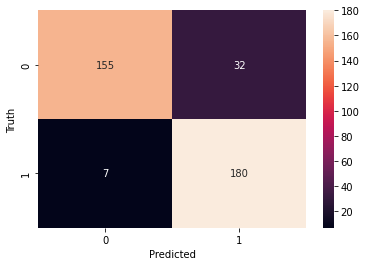

In [64]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [66]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.96      0.83      0.89       187
           1       0.85      0.96      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [65]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)


1/1 [==============================] - 1s 1s/step


array([[0.8120123 ],
       [0.8659536 ],
       [0.8172911 ],
       [0.21468528],
       [0.14500014]], dtype=float32)